In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4-tf


## Enable Eager Mode

In [3]:
tf.enable_eager_execution()

## Hyper Parameters

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.set_random_seed(777)

## Creating a Checkpoint Directory

In [5]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

## MNIST/Fashion MNIST Data

In [6]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    
train_images = train_images.astype(np.float32) / 255. #[0,1] 정규화
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10) # 원핫 인코딩
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11493376/11490434 [==============================] - 1s 0us/step


W0731 15:30:35.679427 15092 deprecation.py:323] From C:\Users\1\Anaconda3\lib\site-packages\tensorflow\python\data\util\random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model Function

In [ ]:
def create_model_backup():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10))
    return model

In [38]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=10, kernel_size=5, 
                      activation=tf.nn.relu, padding='valid', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=20, kernel_size=5, 
                                  activation=tf.nn.relu, padding='VALID'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation=tf.nn.relu))
    model.add(keras.layers.Dense(10))
    return model

In [42]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=5, 
                      activation=tf.nn.relu, padding='same', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=5, 
                                  activation=tf.nn.relu, padding='same'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1000, activation=tf.nn.relu))
    model.add(keras.layers.Dense(10))
    return model

In [43]:
model = create_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              3137000   
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

## Loss Function

In [30]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=labels))    
    return loss   

## Calculating Gradient

In [31]:
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Caculating Model's Accuracy

In [32]:
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## Optimizer

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Creating a Checkpoint

In [34]:
checkpoint = tf.train.Checkpoint(cnn=model)

## Training

In [35]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        grads = grad(model, images, labels)                
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.29620850 train accuracy =  0.9289 test accuracy =  0.9801
Epoch: 2 loss = 0.08107040 train accuracy =  0.9816 test accuracy =  0.9855
Epoch: 3 loss = 0.06043104 train accuracy =  0.9867 test accuracy =  0.9887
Epoch: 4 loss = 0.04965029 train accuracy =  0.9899 test accuracy =  0.9894
Epoch: 5 loss = 0.04229620 train accuracy =  0.9915 test accuracy =  0.9895
Epoch: 6 loss = 0.03778205 train accuracy =  0.9926 test accuracy =  0.9902
Epoch: 7 loss = 0.03372660 train accuracy =  0.9936 test accuracy =  0.9894


KeyboardInterrupt: 

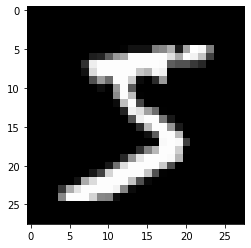

In [74]:
plt.imshow(train_images[0,:,:,0], cmap='gray')

In [85]:
from PIL import Image
img = Image.open('../n3.png')
img_resized = img.resize((28,28))
img_resized

In [81]:
arr = np.array(img_resized)
arr.shape, np.max(arr)

((28, 28, 3), 255)

In [82]:
gray_arr = np.mean(arr, axis=2, keepdims=True)
gray_arr.shape
invert_arr = 1 - gray_arr/255.0

In [83]:
score = model.predict(np.expand_dims(invert_arr,0))

In [84]:
np.argmax(score), score

(9, array([[-0.01500678,  0.04070376, -0.0077638 , -0.06220391, -0.04620686,
         -0.09044865, -0.06063601,  0.03258939, -0.00558329,  0.06135022]],
       dtype=float32))